In [ ]:
import os
import pandas as pd
import datetime as dt
import dateutil.relativedelta
from datetime import timedelta
from sqlalchemy import create_engine, select, MetaData, Table, Integer, String, inspect, Column, ForeignKey

# establish connection
engine = create_engine('sqlite:////Users/marvinchan/Documents/PythonProgramming/DatabaseforStatements/BudgetingProject/transactions_ledger.db', echo=False)
connection = engine.raw_connection()
# to check all table names
inspector = inspect(engine)

In [ ]:
import os
os.getcwd()

In [ ]:
pd.set_option('display.max_rows', 1200)

# Get Data

In [ ]:
inspector.get_table_names()

In [ ]:
start = "2019-10-01" 
end = "2020-03-31"

In [ ]:
transactions_aggregate_categorized = pd.read_sql_query('SELECT * FROM transactions_categorized_train', connection)

In [ ]:
transactions_aggregate_categorized['Description'] = transactions_aggregate_categorized['Description'].replace('[^a-zA-Z ]', '', regex=True)
transactions_aggregate_categorized.loc[transactions_aggregate_categorized['Description'].str.contains('windsor'), 'Description'] = 'windsor'
transactions_aggregate_categorized.loc[transactions_aggregate_categorized['Description'].str.contains('paypal'), 'Description'] = 'paypal'
transactions_aggregate_categorized['Train'] = transactions_aggregate_categorized['Description'] + ' ' + transactions_aggregate_categorized['Amount'].astype(str)

In [ ]:
def _read_categories():
    categories = {}
    
    with open('categories.txt') as f:
        for i, line in enumerate(f.readlines()):
            categories[i] = line.strip()
    return categories

categories = _read_categories()




class Transactions:
    def __init__(self, description, category):
        self.description = description
        self.category = category
        
    def get_category(self):
        for i in categories:
            if self.category == categories[i]:
                return categories[i]
            
            
class Category:
    Income = "Income"
    Rent = "Rent"
    Food = "Food"
    Shopping = "Shopping"
    Gas = "Gas"
    Travel = "Travel"
    Cash = "Cash"
    Pet = "Pet"
    Gifts = "Gifts"
    Gym = "Gym"
    Transfer = "Transfer"
    Groceries = "Groceries"
    Bills = "Bills"
    Uncategorized = "Uncategorized"
    Entertainment = "Entertainment"
    Credit_Card_Reward = "Credit Card Reward"

In [ ]:
categories

In [ ]:
transactions_categorized = transactions_aggregate_categorized.reset_index()[['Description', 'Category']].values.tolist()

In [ ]:
transactions = transactions_aggregate_categorized[['Train', 'Category']]
transaction = [(Transactions(row.Train,row.Category)) for index, row in transactions.iterrows() ] 
transaction[0].description

In [ ]:
print(transaction[1000].amount)

## Train Data

In [ ]:
from sklearn.model_selection import train_test_split

training, test=train_test_split(transaction, test_size=.33, random_state=42)

In [ ]:
train_x = [x.description for x in training]
train_y = [x.category for x in training]

test_x = [x.description for x in test]
test_y = [x.category for x in test]



## Bag of Words

In [153]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

# Classification

### Linear SVM

In [154]:
from sklearn import svm

clf_svm = svm.SVC(C=16, kernel='linear', gamma='auto')

clf_svm.fit(train_x_vectors, train_y)

test_x[0]
# test_x_vectors[0]

clf_svm.predict(test_x_vectors[345])

array(['Transfer'], dtype='<U18')

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
train_x_vectors_gnb = train_x_vectors.todense() 
clf_gnb.fit(train_x_vectors_gnb, train_y)

test_x_vectors_gnb = test_x_vectors.todense()
clf_gnb.predict(test_x_vectors_gnb[0])

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])

## Evaluation

In [155]:
clf_svm.score(test_x_vectors, test_y)

0.9317269076305221

In [ ]:
clf_dec.score(test_x_vectors, test_y)

In [ ]:
clf_gnb.score(test_x_vectors_gnb, test_y)

In [ ]:
clf_log.score(test_x_vectors, test_y)

In [ ]:
train_y.count(Category.Rent)

In [ ]:
test_set = ['transfer paypal']
new_test = vectorizer.transform(test_set)

clf_log.predict(new_test)

## Tuning our model (with Grid Search)

In [157]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [160]:
clf.score(test_x_vectors, test_y)

0.9357429718875502

## F1 Score

In [159]:
from sklearn.metrics import f1_score

f1_score(test_y, clf.predict(test_x_vectors), average=None, labels=[Category.Rent, Category.Income, Category.Food, Category.Shopping, Category.Gas, Category.Travel, Category.Cash, 
                                                                        Category.Pet, Category.Gifts, Category.Gym, Category.Transfer, Category.Groceries, Category.Bills, Category.Uncategorized, Category.Entertainment, 
                                                                       Category.Credit_Card_Reward])

array([0.90909091, 1.        , 0.88607595, 0.95652174, 0.89473684,
       0.97142857, 0.95890411, 0.85714286, 1.        , 1.        ,
       1.        , 0.95327103, 0.92857143, 0.4       , 0.91666667,
       1.        ])

## Saving Model

In [ ]:
import pickle

with open('categorizer.pkl', 'wb') as f:
    pickle.dump(clf, f)
with open('vectorizer.pkl', 'wb') as f:    
    pickle.dump(vectorizer, f)

# Load Model

In [ ]:
with open('categorizer.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [ ]:
print(test_x[0])
loaded_clf.predict(test_x_vectors[0])

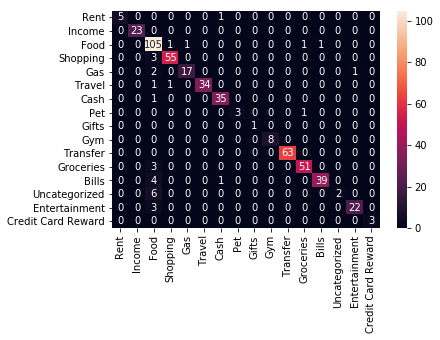

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = clf.predict(test_x_vectors)

labels = [Category.Rent, Category.Income, Category.Food, Category.Shopping, Category.Gas, Category.Travel, Category.Cash, 
                                                                        Category.Pet, Category.Gifts, Category.Gym, Category.Transfer, Category.Groceries, Category.Bills, Category.Uncategorized, Category.Entertainment, 
                                                                       Category.Credit_Card_Reward]
cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('confusion.png', dpi = 300, bbox_inches='tight')